In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import play
from qlearner import QPlayer, QStateAction
from tic_env import OptimalPlayer
import random
from collections import defaultdict
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid


# Fix seed for reproducibility
random.seed(0)
np.random.seed(0)

In [3]:
def read_grid(grid):
    empty = list(zip(*np.where(grid==0)))
    filled = list(zip(*np.where(grid!=0)))
    return empty, filled

In [4]:
def save_stats(players, path):
    player_stats = []
    
    for player in players:
        
        stat = {
            'reward': player.avg_rewards,
            'm_opt': player.m_values['m_opt'],
            'm_rand': player.m_values['m_rand']
        }
        player_stats.append(stat)
        
    with open(path, 'wb') as npy:
        np.save(npy, player_stats)
        

In [46]:
def plot_average_rewards(stats_path, labels, log_every=250, save_path=None):
    try:
        with open(stats_path, 'rb') as npy:
            player_stats = np.load(npy, allow_pickle=True)
    except:
        print('File not found!')
        raise
        
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    game_ids = list(range(0, len(player_stats[0]['reward'])*log_every, log_every))
    for i, player in enumerate(player_stats):
        label = labels[i]
        ax.plot(game_ids, player['reward'], label=label)
    
    ax.set_title(f'Average reward per {log_every} games', fontsize=20, fontweight='bold')
    ax.set_xlabel('Game', fontsize=16)
    ax.set_ylabel('Reward', fontsize=16)
    ax.set_xlim([0, len(game_ids)*log_every])
    ax.legend(loc='lower right')
    ax.grid()

    plt.show()
    
    if save_path is not None: fig.savefig(save_path, format='pdf')
    

In [47]:
def plot_m_values(stats_path, labels, test_every=250, save_path=None):
    try:
        with open(stats_path, 'rb') as npy:
            player_stats = np.load(npy, allow_pickle=True)
    except:
        print('File not found!')
        raise
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    game_ids = list(range(0, len(player_stats[0]['reward'])*test_every, test_every))
    for i, player in enumerate(player_stats):
        label = labels[i]
        axes[0].plot(game_ids, player["m_opt"], label=label)
        axes[1].plot(game_ids, player["m_rand"], label=label)

        
    axes[0].set_title(f'M_opt per {test_every} games', fontsize=20, fontweight='bold')
    axes[0].set_xlabel('Game', fontsize=16)
    axes[0].set_ylabel('M_opt', fontsize=16)
    axes[0].set_xlim([0, len(game_ids)*test_every])
    axes[0].legend()
    axes[0].grid()
    
    axes[1].set_title(f'M_rand per {test_every} games', fontsize=20, fontweight='bold')
    axes[1].set_xlabel('Game', fontsize=16)
    axes[1].set_ylabel('M_rand', fontsize=16)
    axes[1].set_xlim([0, len(game_ids)*test_every])
    axes[1].legend()
    axes[1].grid()

    plt.show()
    
    if save_path is not None: fig.savefig(save_path, format='pdf')
    

In [48]:
def plot_heatmaps(states_list, qvalues_list, titles, cmap=None, save_path=None):
    fig = plt.figure(figsize=(15, 5))
    axes = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.2,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
    
    if cmap is None: cmap = plt.cm.get_cmap('Blues', 10)
    
    for ax, state, qvalues, title in zip(axes, states_list, qvalues_list, titles):
        
        empty, filled = read_grid(state) # Read the configuration of the grid
        qvalue_grid = -1*np.ones((3,3))

        for action in empty:
            qstate = QStateAction(state, action)
            qvalue_grid[action] = qvalues.get(qstate, 0)
        

        img = ax.imshow(qvalue_grid, cmap=cmap, vmin=-1, vmax=1)
        ax.set_axis_off()

        for i, j in empty:
            qval = qvalue_grid[i, j]
            text = ax.text(j, i, f'{qval:.3f}', ha='center', va='center', color='k', fontsize=14)

        for i, j in filled:
            player = 'X' if state[i, j] == 1 else 'O'
            text = ax.text(j, i, f'{player}', ha='center', va='center', color='k', fontsize=16, fontweight='bold')
            
        
        ax.set_title(title, fontsize=14, fontweight='bold')
            
            
    cbar = ax.cax.colorbar(img)
    cbar = axes.cbar_axes[0].colorbar(img)


    if save_path is not None: fig.savefig(save_path, format='pdf')

### Q1

In [44]:
epsilons = [0.01, 0.1, 0.2, 0.5, 0.75]
eps_q_players = []

for eps in epsilons:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=eps, log_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    eps_q_players.append(q_player)
    

save_stats(players=eps_q_players, path='answers/Q1.npy')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:18<00:00, 253.55it/s]


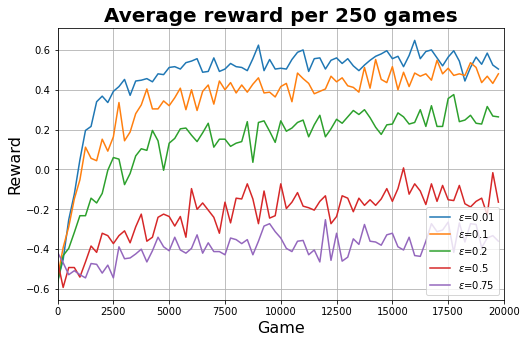

In [49]:
epsilons = [0.01, 0.1, 0.2, 0.5, 0.75]
labels = [f'$\epsilon$={eps}' for eps in epsilons]

plot_average_rewards('answers/Q1.npy', labels=labels, save_path='artifacts/fig_Q1.pdf')

### Q2

In [118]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 100, 1000, 10000, 40000]
n_star_players = []


for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=get_epsilon, log_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    n_star_players.append(q_player)
    
save_stats(players=n_star_players, path='answers/Q2.npy')
    

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

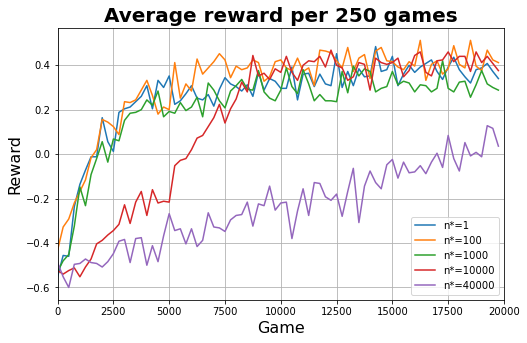

In [50]:
n_stars = [1, 100, 1000, 10000, 40000]
labels = [f'n*={n_star}' for n_star in n_stars]

plot_average_rewards(stats_path='answers/Q2.npy', labels=labels, save_path='artifacts/fig_Q2.pdf')

### Q3

In [128]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 100, 1000, 10000, 40000]
n_star_players = []

for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=get_epsilon, log_every=250, test_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    n_star_players.append(q_player)
    
save_stats(players=n_star_players, path='answers/Q3.npy')


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

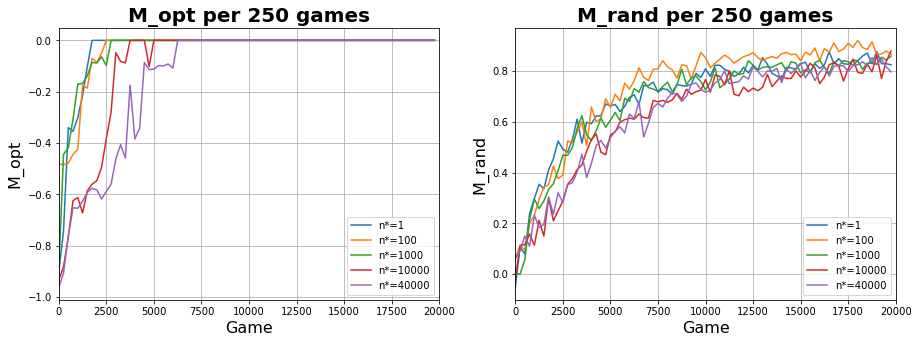

In [51]:
n_stars = [1, 100, 1000, 10000, 40000]
labels = [f"n*={n_star}" for n_star in n_stars]

plot_m_values(stats_path='answers/Q3.npy', labels=labels, save_path='artifacts/fig_Q3.pdf')

### Q4

In [132]:
N_STAR = 100
EPS_MIN = 0.1
EPS_MAX = 0.8
get_epsilon = lambda n: max(EPS_MIN, EPS_MAX * (1 - n / N_STAR))

epsilons = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 1]

eps_players = []

for eps in epsilons:
    other_player = OptimalPlayer(epsilon=eps)
    q_player = QPlayer(epsilon=get_epsilon, log_every=250, test_every=250)
    play(other_player, q_player, episodes=20000)
    eps_players.append(q_player)
    
save_stats(players=eps_players, path='answers/Q4.npy')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

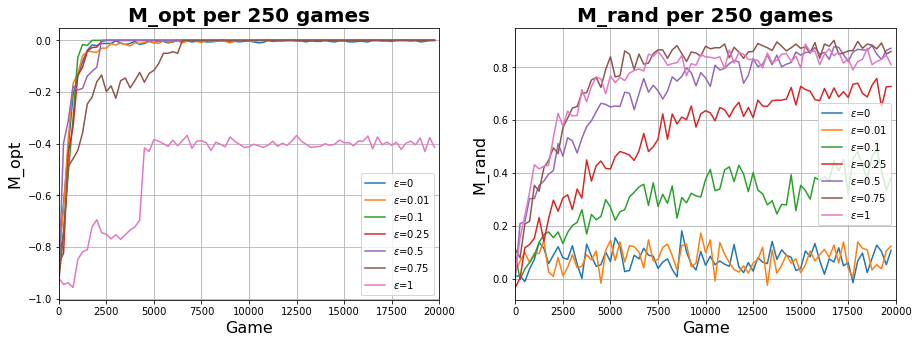

In [52]:
epsilons = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 1]
labels = [f'$\epsilon$={eps}' for eps in epsilons]

plot_m_values(stats_path='answers/Q4.npy', labels=labels, save_path='artifacts/fig_Q4.pdf')

### Q7

In [141]:
epsilons = [0.01, 0.1, 0.2, 0.5]
self_q_players = []

for eps in epsilons:
    qvalues = defaultdict(int)
    q_player1 = QPlayer(epsilon=eps, qvalues=qvalues, log_every=250, test_every=250)
    q_player2 = QPlayer(epsilon=eps, qvalues=qvalues, log_every=250, test_every=250)
    play(q_player1, q_player2, episodes=20000)
    self_q_players.append(q_player1)
    

save_stats(players=self_q_players, path='answers/Q7.npy')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

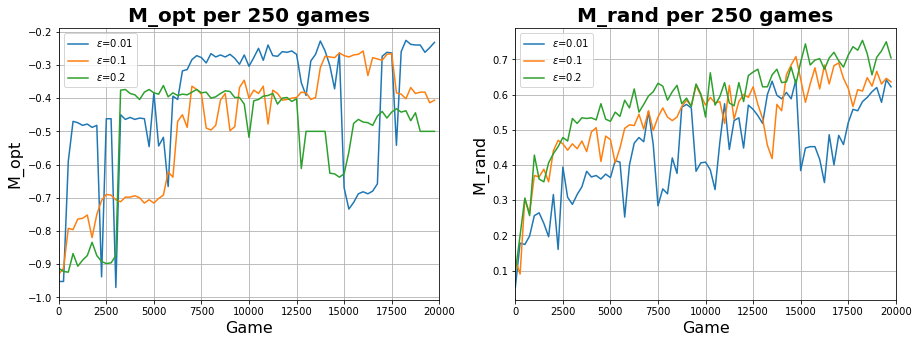

In [53]:
epsilons = [0.01, 0.1, 0.2, 0.5]
labels = [f'$\epsilon$={eps}' for eps in epsilons]

plot_m_values(stats_path='answers/Q7.npy', labels=labels, save_path='artifacts/fig_Q7.pdf')

### Q8

In [6]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 100, 1000, 10000, 40000]
self_n_star_players = []

for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    qvalues = defaultdict(int)
    q_player1 = QPlayer(epsilon=get_epsilon, qvalues=qvalues, log_every=250, test_every=250)
    q_player2 = QPlayer(epsilon=get_epsilon, qvalues=qvalues, log_every=250, test_every=250)
    play(q_player1, q_player2, episodes=20000)
    self_n_star_players.append(q_player1)
    
save_stats(players=self_n_star_players, path='answers/Q8.npy')


qvalues = [player.qvalues for player in self_n_star_players]
with open('answers/Q10.npy', 'wb') as npy:
    np.save(npy, qvalues)

100%|██████████| 20000/20000 [10:14<00:00, 32.53it/s]


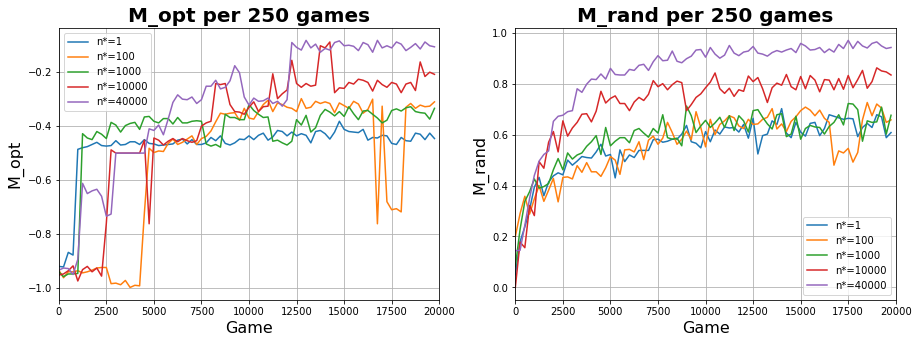

In [54]:
n_stars = [1, 100, 1000, 10000, 40000]
labels = [f'n*={n_star}' for n_star in n_stars]

plot_m_values(stats_path='answers/Q8.npy', labels=labels, save_path='artifacts/fig_Q8.pdf')

### Q10

In [14]:
with open('answers/Q10.npy', 'rb') as npy:
    qvalues = np.load(npy, allow_pickle=True)

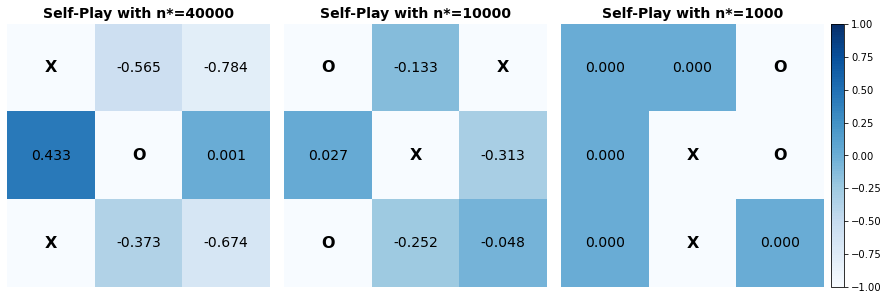

In [55]:
state1 = np.array([
    [1.0, 0.0, 0.0],
    [0.0, -1.0, 0.0],
    [1.0, 0.0, 0.0],
])

state2 = np.array([
    [-1.0, 0.0, 1.0],
    [0.0, 1.0, 0.0],
    [-1.0, 0.0, 0.0],
])

state3 = np.array([
    [0.0, 0.0, -1.0],
    [0.0, 1.0, -1.0],
    [0.0, 1.0, 0.0],
])

states_list = [state1, state2, state3]
qvalues_list = [qvalues[4], qvalues[3], qvalues[2]]
titles=[f'Self-Play with n*={n_star}' for n_star in [40000, 10000, 1000]]
cmap = plt.cm.get_cmap('Blues', 100)

plot_heatmaps(states_list, qvalues_list, titles=titles, cmap=cmap, save_path='artifacts/fig_Q10.pdf')